# ML Performance on Real Triaging Data

The components of this notebook are a combination of two university tasks. 

The first task was to find two datasets that create a data story. The presentation delivered is available on request. 
The second task involved a bias examination of the dataset and evaluation on methodologies.

This notebook will focus on the code to create the models required.

Some skills demonstrated are Data Cleaning, Natural Langauge Processing and Model Training/Optimisation.

### Importing Required Libraries

In [1]:
#Data Manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import random
#NLP for Chief Complaint
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#MachineLearning
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB


In [2]:
from random import seed
# maintaining a controlled environment for testing
random.seed(37)

### Importing and Inspecting Data

In [3]:
nurse_file = "data.csv"
nurse_df = pd.read_csv(nurse_file, sep = ";", encoding='latin-1')

In [4]:
nurse_df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1
3,1,2,71,8,1,1,ascites tapping,1,1,3,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1
4,1,2,58,4,3,1,"distension, abd",1,1,3,...,36.5,NaN,4,Ascites,1,5,8,109,"6,60",1


In [5]:
nurse_df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage'],
      dtype='object')

In [6]:
nurse_df.dtypes
# Checking for correct data types.

Group                        int64
Sex                          int64
Age                          int64
Patients number per hour     int64
Arrival mode                 int64
Injury                       int64
Chief_complain              object
Mental                       int64
Pain                         int64
NRS_pain                    object
SBP                         object
DBP                         object
HR                          object
RR                          object
BT                          object
Saturation                  object
KTAS_RN                      int64
Diagnosis in ED             object
Disposition                  int64
KTAS_expert                  int64
Error_group                  int64
Length of stay_min           int64
KTAS duration_min           object
mistriage                    int64
dtype: object

In [7]:
nurse_df.shape

(1267, 24)

Content - Description Available with Original Dataset

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0216972


Variables:
- Sex: Sex of the patient
- Age: Age of the patient
- Arrival mode: Type of transportation to the hospital
- Injury: Whether the patient is injured or not
- Chief_complain: The patient's complaint
- Mental: The mental state of the patient
- Pain: Whether the patient has pain
- NRS_pain: Nurse's assessment of pain for the patient
- SBP: Systolic Blood Pressure.
- DBP: Diastolic Blood Pressure.
- HR: Heat Rate.
- RR: Respiratory rate
- BT: Body Temperature

The technical document in the project of the data set has been reached. It was seen in this document that some numerical data were actually categorical. These values are as follows:

- Reason Visit : Injury [1 = No, 2= Yes]
- Gender : Sex [1 = Female, 2 = Male]
- Pain : Pain [1 = Yes, 0 = No]
- Mental : Mental status [1 = Alert, 2 = Verbal Response, 3 = Pain Response, 4 = Unresponse]
- Type of ED : Group [1 = Local ED 3th Degree, 2 = Regional ED 4tg Degree]
- Mode of Arrival : Arrival Mode [1 = Walking, 2 = Public Ambulance, 3 = Private Vehicle, 4 = Private Ambulance, 5,6,7 = Other]
- Disposition : Disposition [1 = Dischange, 2 = Admission to ward, 3 = Admission to ICU, 4 = Disharge, 5 = Transfer, 6 = Death, 7 = Surgery]
- KTAS : KTAS… [1,2,3 = Emergency, 4,5 = Non-Emergency]
- Error Group: [1: Vital sign / 2: Physical exam / 3: Psychatric /4: Pain / 5: Mental / 6: Underlying disease / 7: Medical records of other ED / 8: On set / 9: Others] #Method in which the error lead to a mistriage

In [8]:
Gender = ['Female', 'Male']
Injury = [1, 2]

In [9]:
nurse_df['Gender'] = nurse_df['Sex'].apply(lambda row: 1 if row == 2 else 0)
nurse_df['Injury'] = nurse_df['Group'].apply(lambda row: 1 if row == 2 else 0)
nurse_df['NRS_pain'] = nurse_df["NRS_pain"].replace("#BO�!",np.NaN)

In [10]:
def numeric_conversion(column_name):
    new_list = []
    for item in nurse_df[column_name]:
        try:
            item = int(str(item))
        except:
            item = -1
        new_list.append(item)
    nurse_df[column_name] = new_list

def float_conversion(column_name):
    new_list = []
    for item in nurse_df[column_name]:
        try:
            item = float(str(item))
        except:
            item = -1
        new_list.append(item)
    nurse_df[column_name] = new_list
        

In [11]:
wrong_dt_list = ['NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'Saturation']
for item in wrong_dt_list:
    numeric_conversion(item)

float_conversion('BT')

In [12]:
human_compare = nurse_df[['KTAS_RN', 'KTAS_expert']]

In [13]:
nurse_df[nurse_df['Saturation'] > 0]

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,Gender
0,2,2,71,3,3,1,right ocular pain,1,1,2,...,100,2,Corneal abrasion,1,4,2,86,"5,00",1,1
2,2,1,68,8,2,1,"arm pain, Lt",1,1,2,...,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1,0
5,2,1,54,6,4,1,fever,1,1,3,...,98,3,"Fever, unspecified",2,4,1,9246,"2,00",1,0
6,2,2,49,11,3,1,With chest discomfort,1,1,3,...,98,2,"Angina pectoris, unspecified",1,3,2,400,"3,00",1,1
9,2,1,38,6,3,1,"Eczema, Eyelid",1,1,3,...,97,4,Ocular pain,1,5,4,185,"4,00",1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,2,2,79,5,2,1,mental change,1,0,-1,...,95,2,Cerebral infarction due to unspecified occlusi...,2,2,0,1995,"3,00",0,1
1263,2,2,81,2,3,1,dysuria,1,0,-1,...,97,4,Dysuria,1,4,0,1000,"2,00",0,1
1264,2,2,81,17,2,1,dizziness,1,0,-1,...,99,3,Dizziness and giddiness,1,3,0,310,"4,00",0,1
1265,2,1,81,2,2,1,"Sensory, Decreased",1,0,-1,...,98,3,"Cord compression, unspecified",7,3,0,475,"5,00",0,0


### Comparison to Humans

This dataset was unique in that it held human predictions along with true variables. This allowed for a fascinating exploration into nursing performance.

In [14]:
human_compare.head()

,KTAS_RN,KTAS_expert
0,2,4
1,4,5
2,4,5
3,4,5
4,4,5


In [15]:
human_compare['KTAS_expert'].value_counts()

3    487
4    459
2    220
5     75
1     26
Name: KTAS_expert, dtype: int64

In [16]:
human_compare.dtypes

KTAS_RN        int64
KTAS_expert    int64
dtype: object

In [17]:
human_compare['CAT_RN'] = human_compare.loc[:,'KTAS_RN'].apply(lambda x: 1 if x <= 3 else 0)
human_compare['CAT_EXPERT'] = human_compare.loc[:,'KTAS_expert'].apply(lambda x: 1 if x<= 3 else 0)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3489706699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_compare['CAT_RN'] = human_compare.loc[:,'KTAS_RN'].apply(lambda x: 1 if x <= 3 else 0)
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3489706699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_compare['CAT_EXPERT'] = human_compare.loc[:,'KTAS_expert'].apply(lambda x: 1 if x<= 3 else 0)


In [18]:
human_compare

,KTAS_RN,KTAS_expert,CAT_RN,CAT_EXPERT
0,2,4,1,0
1,4,5,0,0
2,4,5,0,0
3,4,5,0,0
4,4,5,0,0
...,...,...,...,...
1262,2,2,1,1
1263,4,4,0,0
1264,3,3,1,1
1265,3,3,1,1


### Feature Engineering/Selection

The dataset needed to be split into predictors and outcomes. I have observed other Kaggle projects that have used the outcomes in the prediction which will have heavily biased the machine learning model and not produced any useful or meaningful model.

In [19]:
nurse_df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage', 'Gender'],
      dtype='object')

In [20]:
features = ['Gender', 'Age', 'Arrival mode', 'NRS_pain', 'Injury', 'Chief_complain', 'Mental', 'Pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_expert', 'Diagnosis in ED']

In [21]:
train_df = nurse_df[features]

In [22]:
train_df.head()

,Gender,Age,Arrival mode,NRS_pain,Injury,Chief_complain,Mental,Pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_expert,Diagnosis in ED
0,1,71,3,2,1,right ocular pain,1,1,160,100,84,18,36.6,100,4,Corneal abrasion
1,0,56,3,2,0,right forearm burn,1,1,137,75,60,20,36.5,-1,5,"Burn of hand, firts degree dorsum"
2,0,68,2,2,1,"arm pain, Lt",1,1,130,80,102,20,36.6,98,5,"Fracture of surgical neck of humerus, closed"
3,1,71,1,3,0,ascites tapping,1,1,139,94,88,20,36.5,-1,5,Alcoholic liver cirrhosis with ascites
4,1,58,3,3,0,"distension, abd",1,1,91,67,93,18,36.5,-1,5,Ascites


In [23]:
train_df.dtypes

Gender               int64
Age                  int64
Arrival mode         int64
NRS_pain             int64
Injury               int64
Chief_complain      object
Mental               int64
Pain                 int64
SBP                  int64
DBP                  int64
HR                   int64
RR                   int64
BT                 float64
Saturation           int64
KTAS_expert          int64
Diagnosis in ED     object
dtype: object

In [24]:
train_df.isna().any()
# Inspection for Null Values

Gender             False
Age                False
Arrival mode       False
NRS_pain           False
Injury             False
Chief_complain     False
Mental             False
Pain               False
SBP                False
DBP                False
HR                 False
RR                 False
BT                 False
Saturation         False
KTAS_expert        False
Diagnosis in ED     True
dtype: bool

The dataset also needs to be inspected for outliers and null values. As can be seen below there are numerous values (i.e. -1) that need to be addressed. To correct this these will be imputed with either mean or median depending on a normal or skewed distribution respectively.

In [25]:
train_df.describe()

,Gender,Age,Arrival mode,NRS_pain,Injury,Mental,Pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_expert
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,0.521705,54.423836,2.820837,1.864246,0.456985,1.105762,0.563536,130.992107,77.902131,82.621942,19.150750,36.046725,43.099448,3.265983
std,0.499726,19.725033,0.807904,2.747777,0.498343,0.447768,0.496143,32.866837,19.338546,19.618597,3.343217,4.482012,48.871801,0.885803
min,0.000000,16.000000,1.000000,-1.000000,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.000000,37.000000,2.000000,-1.000000,0.000000,1.000000,0.000000,110.000000,70.000000,72.000000,18.000000,36.200000,-1.000000,3.000000
50%,1.000000,57.000000,3.000000,3.000000,0.000000,1.000000,1.000000,130.000000,80.000000,81.000000,20.000000,36.500000,-1.000000,3.000000
75%,1.000000,71.000000,3.000000,4.000000,1.000000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,98.000000,4.000000
max,1.000000,96.000000,7.000000,10.000000,1.000000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,41.000000,100.000000,5.000000


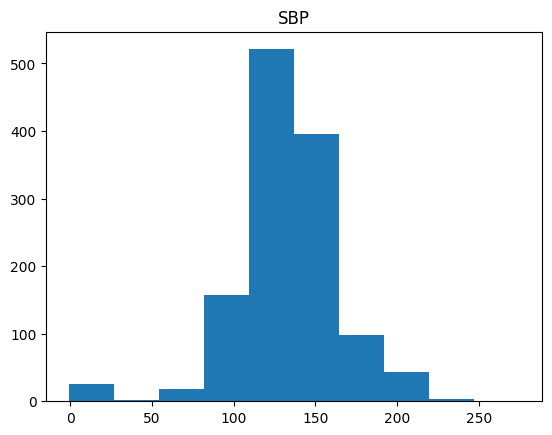

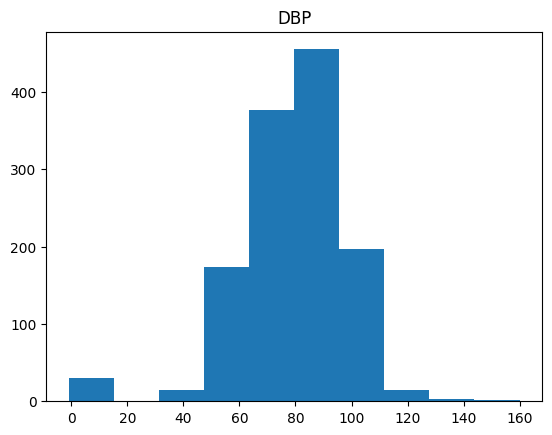

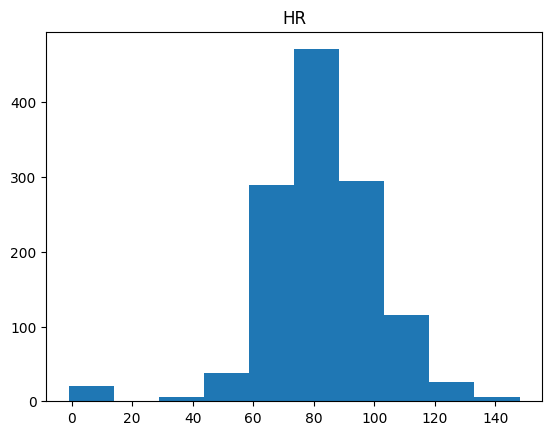

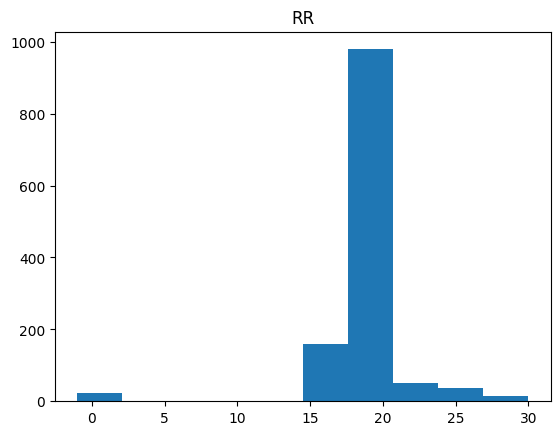

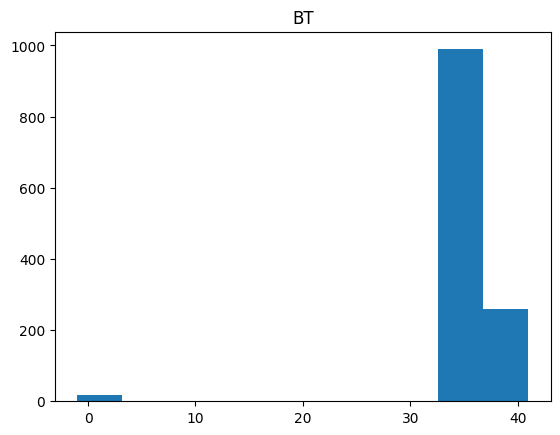

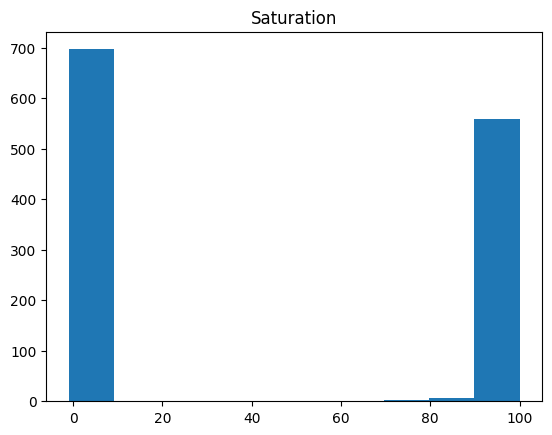

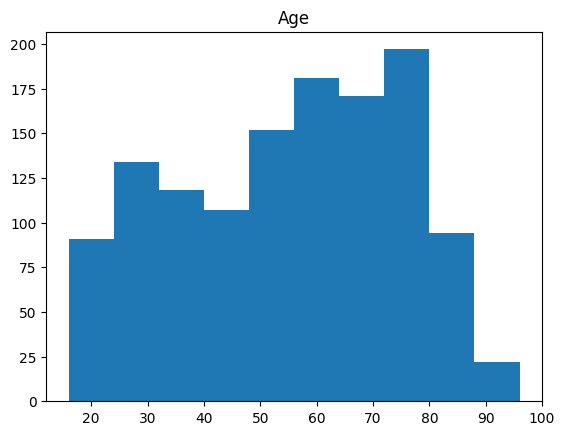

<Figure size 640x480 with 0 Axes>

In [26]:
def distribution_plot(outlier_list):
    for item in outlier_list:
        plt.hist(train_df[item])
        plt.title(str(item))
        plt.show()
        plt.clf()

outliers = ['SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'Age']
distribution_plot(outliers)

In [27]:
def neg_replacer(outlist):
    for item in outlist:
        train_df[item].replace(-1, train_df[train_df[item] >= 0][item].mean(), inplace = True)

neg_replacer(outliers)
train_df['NRS_pain'].replace(-1, train_df[train_df['NRS_pain'] >= 0].NRS_pain.median(), inplace = True)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3228875152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[item].replace(-1, train_df[train_df[item] >= 0][item].mean(), inplace = True)
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3228875152.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['NRS_pain'].replace(-1, train_df[train_df['NRS_pain'] >= 0].NRS_pain.median(), inplace = True)


In [28]:
train_df.describe()

,Gender,Age,Arrival mode,NRS_pain,Injury,Mental,Pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_expert
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,0.521705,54.423836,2.820837,4.058406,0.456985,1.105762,0.563536,133.648953,79.815683,83.963111,19.506827,36.580624,97.024561,3.265983
std,0.499726,19.725033,0.807904,1.064165,0.498343,0.447768,0.496143,27.004987,14.929058,16.512102,1.999050,0.541815,2.916648,0.885803
min,0.000000,16.000000,1.000000,1.000000,0.000000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000
25%,0.000000,37.000000,2.000000,3.000000,0.000000,1.000000,0.000000,115.000000,70.000000,72.000000,18.000000,36.200000,97.024561,3.000000
50%,1.000000,57.000000,3.000000,4.000000,0.000000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,97.024561,3.000000
75%,1.000000,71.000000,3.000000,4.000000,1.000000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,98.000000,4.000000
max,1.000000,96.000000,7.000000,10.000000,1.000000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,41.000000,100.000000,5.000000


In [29]:
human_compare.head()

,KTAS_RN,KTAS_expert,CAT_RN,CAT_EXPERT
0,2,4,1,0
1,4,5,0,0
2,4,5,0,0
3,4,5,0,0
4,4,5,0,0


In [30]:
train_df.dtypes

Gender               int64
Age                  int64
Arrival mode         int64
NRS_pain             int64
Injury               int64
Chief_complain      object
Mental               int64
Pain                 int64
SBP                float64
DBP                float64
HR                 float64
RR                 float64
BT                 float64
Saturation         float64
KTAS_expert          int64
Diagnosis in ED     object
dtype: object

### NLP

Another key component for the diagnosis is the ED diagnosis and ED presentation. As mentioned previously, a big challenge with this dataset is the combination of Korean, English and inconsistent data.

In [31]:
def preprocessing(text):
    text = text.lower()
    tokenwords = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemming = WordNetLemmatizer()
    words = [lemming.lemmatize(word) for word in tokenwords if word.lower() not in stop_words]
    preprocessed_text = ' '.join(words)
    return preprocessed_text


In [32]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /Users/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
train_df['Chief_complain'] = train_df['Chief_complain'].apply(preprocessing)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3911833675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Chief_complain'] = train_df['Chief_complain'].apply(preprocessing)


In [34]:
nullvalues = []

nullvalues = []

def append_to_nullvalues(x):
    if type(x) == float:
        nullvalues.append(x)

train_df['Diagnosis in ED'].apply(append_to_nullvalues)

0       None
1       None
2       None
3       None
4       None
        ... 
1262    None
1263    None
1264    None
1265    None
1266    None
Name: Diagnosis in ED, Length: 1267, dtype: object

In [35]:
print(nullvalues)

[nan, nan]


In [36]:
train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].replace(np.NaN, "Unknown")

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/2311991692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].replace(np.NaN, "Unknown")


In [37]:
train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].apply(preprocessing)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/815294157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].apply(preprocessing)


In [38]:
target = train_df['KTAS_expert'].values
print(len(target))
target_c = human_compare['CAT_EXPERT']
print(len(target_c))

1267
1267


In [39]:
target_c

0       0
1       0
2       0
3       0
4       0
       ..
1262    1
1263    0
1264    1
1265    1
1266    1
Name: CAT_EXPERT, Length: 1267, dtype: int64

# FAIRNESS ATTRIBUTES

Gender and Age are potentially protected attributes to investigate.

In [40]:
import aif360
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [41]:
# Load your dataset
fairness_df = train_df
fairness_df['Emergency'] = target_c
fairness_df = fairness_df.drop(labels = ['Diagnosis in ED', 'Chief_complain', 'KTAS_expert'], axis=1)

# Define the protected attribute and its privileged class
protected_attribute_name = 'Gender'
privileged_classes = [1]  # Specify the privileged class

dataset = StandardDataset(
    fairness_df,
    label_name='Emergency',
    protected_attribute_names=[protected_attribute_name],  # Use a list for protected_attribute_names
    privileged_classes=[privileged_classes],
    favorable_classes=[1]  # Corrected parameter name
)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/2497585496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_df['Emergency'] = target_c


In [42]:
# Create a metric object
metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected_attribute_name: 1}], unprivileged_groups=[{protected_attribute_name: 0}])

# Compute disparate impact
disparate_impact = metric.disparate_impact()
parity_difference = metric.statistical_parity_difference()
print("Disparate Impact:", round(disparate_impact, 3))
print("Stastistical Parity:", round(parity_difference, 3))


Disparate Impact: 1.036
Stastistical Parity: 0.02


In [43]:
age_bias_impact = []
age_bias_stats = []
for i in [20, 30, 40, 50, 60, 70, 80]:
    # Load your dataset
    fairness_df = train_df
    fairness_df['Emergency'] = target_c
    fairness_df['Age_Bin'] = fairness_df['Age'].apply(lambda row: 1 if row <= i else 0)
    fairness_df = fairness_df.drop(labels = ['Diagnosis in ED', 'Chief_complain', 'KTAS_expert', 'Age'], axis=1)

# Define the protected attribute and its privileged class
    protected_attribute_name = 'Age_Bin'
    privileged_classes = [1]  # Specify the privileged class

    dataset = StandardDataset(
        fairness_df,
        label_name='Emergency',
        protected_attribute_names=[protected_attribute_name],  # Use a list for protected_attribute_names
        privileged_classes=[privileged_classes],
        favorable_classes=[1]  # Corrected parameter name
    )
    # Create a metric object
    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected_attribute_name: 1}], unprivileged_groups=[{protected_attribute_name: 0}])

    # Compute disparate impact
    disparate_impact = metric.disparate_impact()
    parity_difference = metric.statistical_parity_difference()
    age_bias_impact.append(disparate_impact)
    age_bias_stats.append(parity_difference)
    print(f'Bias for Age Cut-offs of {i}')
    print("Disparate Impact:", round(disparate_impact, 3))
    print("Stastistical Parity:", round(parity_difference, 3))  

Bias for Age Cut-offs of 20
Disparate Impact: 1.587
Stastistical Parity: 0.217
Bias for Age Cut-offs of 30
Disparate Impact: 1.49
Stastistical Parity: 0.201
Bias for Age Cut-offs of 40
Disparate Impact: 1.446
Stastistical Parity: 0.195
Bias for Age Cut-offs of 50
Disparate Impact: 1.428
Stastistical Parity: 0.197
Bias for Age Cut-offs of 60
Disparate Impact: 1.357
Stastistical Parity: 0.18
Bias for Age Cut-offs of 70
Disparate Impact: 1.231
Stastistical Parity: 0.126
Bias for Age Cut-offs of 80
Disparate Impact: 1.285
Stastistical Parity: 0.161


/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3975190382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_df['Emergency'] = target_c
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3975190382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_df['Age_Bin'] = fairness_df['Age'].apply(lambda row: 1 if row <= i else 0)
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/3975190382.py:6: SettingWithCopyWarning: 
A value is trying to be set o

<function matplotlib.pyplot.clf()>

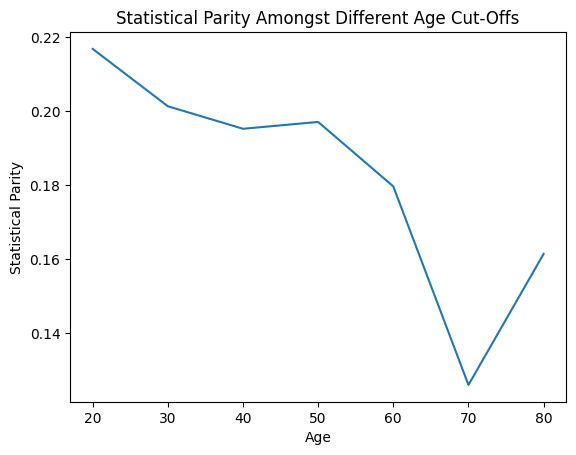

In [44]:
plt.plot([20, 30, 40, 50, 60, 70, 80], age_bias_stats)
plt.title('Statistical Parity Amongst Different Age Cut-Offs')
plt.xlabel('Age')
plt.ylabel('Statistical Parity')
plt.clf

<function matplotlib.pyplot.clf()>

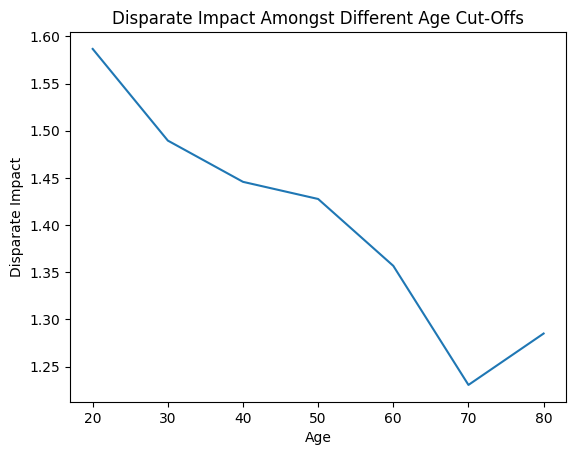

In [45]:
plt.plot([20, 30, 40, 50, 60, 70, 80], age_bias_impact)
plt.title('Disparate Impact Amongst Different Age Cut-Offs')
plt.xlabel('Age')
plt.ylabel('Disparate Impact')
plt.clf

In [46]:
# Load your dataset
fairness_df = train_df
fairness_df['Emergency'] = human_compare['CAT_RN']
fairness_df = fairness_df.drop(labels = ['Diagnosis in ED', 'Chief_complain'], axis=1)

# Define the protected attribute and its privileged class
protected_attribute_name = 'Gender'
privileged_classes = [1]  # Specify the privileged class

dataset = StandardDataset(
    fairness_df,
    label_name='Emergency',
    protected_attribute_names=[protected_attribute_name],  # Use a list for protected_attribute_names
    privileged_classes=[privileged_classes],
    favorable_classes=[1]  # Corrected parameter name
)

# Create a metric object
metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected_attribute_name: 1}], unprivileged_groups=[{protected_attribute_name: 0}])
# Compute disparate impact
nurse_disparate_impact = metric.disparate_impact()
nurse_parity_difference = metric.statistical_parity_difference()
print(f'Bias for Nurses in Gender')
print("Disparate Impact:", round(disparate_impact, 3))
print("Stastistical Parity:", round(parity_difference, 3)) 

Bias for Nurses in Gender
Disparate Impact: 1.285
Stastistical Parity: 0.161


/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/964175210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_df['Emergency'] = human_compare['CAT_RN']


In [47]:
nurse_age_bias_impact = []
nurse_age_bias_stats = []
for i in [20, 30, 40, 50, 60, 70, 80]:
    # Load your dataset
    fairness_df = train_df
    fairness_df['Emergency'] = human_compare['CAT_RN']
    fairness_df['Age_Bin'] = fairness_df['Age'].apply(lambda row: 1 if row <= i else 0)
    fairness_df = fairness_df.drop(labels = ['Diagnosis in ED', 'Chief_complain', 'KTAS_expert', 'Age'], axis=1)

# Define the protected attribute and its privileged class
    protected_attribute_name = 'Age_Bin'
    privileged_classes = [1]  # Specify the privileged class

    dataset = StandardDataset(
        fairness_df,
        label_name='Emergency',
        protected_attribute_names=[protected_attribute_name],  # Use a list for protected_attribute_names
        privileged_classes=[privileged_classes],
        favorable_classes=[1]  # Corrected parameter name
    )
    # Create a metric object
    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected_attribute_name: 1}], unprivileged_groups=[{protected_attribute_name: 0}])

    # Compute disparate impact
    disparate_impact = metric.disparate_impact()
    parity_difference = metric.statistical_parity_difference()
    nurse_age_bias_impact.append(disparate_impact)
    nurse_age_bias_stats.append(parity_difference)
    print(f'Bias for Age Cut-offs of {i}')
    print("Disparate Impact:", round(disparate_impact, 3))
    print("Stastistical Parity:", round(parity_difference, 3))  
    

Bias for Age Cut-offs of 20
Disparate Impact: 1.561
Stastistical Parity: 0.195
Bias for Age Cut-offs of 30
Disparate Impact: 1.687
Stastistical Parity: 0.234
Bias for Age Cut-offs of 40
Disparate Impact: 1.506
Stastistical Parity: 0.199
Bias for Age Cut-offs of 50
Disparate Impact: 1.434
Stastistical Parity: 0.185
Bias for Age Cut-offs of 60
Disparate Impact: 1.362
Stastistical Parity: 0.169
Bias for Age Cut-offs of 70
Disparate Impact: 1.216
Stastistical Parity: 0.11
Bias for Age Cut-offs of 80
Disparate Impact: 1.27
Stastistical Parity: 0.142


/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/707613325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_df['Emergency'] = human_compare['CAT_RN']
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/707613325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_df['Age_Bin'] = fairness_df['Age'].apply(lambda row: 1 if row <= i else 0)
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_37962/707613325.py:6: SettingWithCopyWarning: 
A value is trying

<function matplotlib.pyplot.clf()>

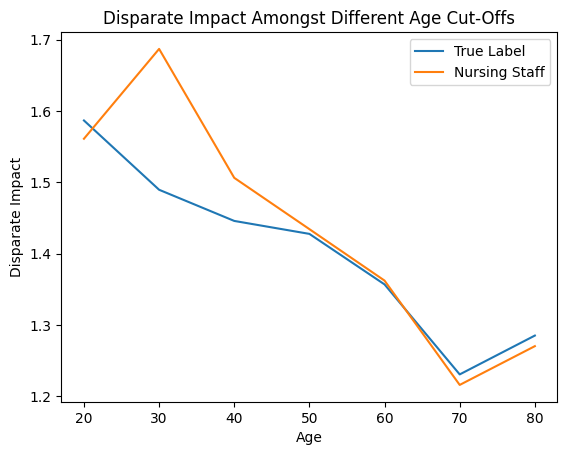

In [48]:
plt.plot([20, 30, 40, 50, 60, 70, 80], age_bias_impact[:7], label = 'True Label')
plt.plot([20, 30, 40, 50, 60, 70, 80], nurse_age_bias_impact, label = "Nursing Staff")
plt.title('Disparate Impact Amongst Different Age Cut-Offs')
plt.xlabel('Age')
plt.ylabel('Disparate Impact')
plt.legend(loc = 1)
plt.clf

In [49]:
print(age_bias_stats)
print(nurse_age_bias_stats)

[0.21683936901328205, 0.20132065926458448, 0.1952246582632533, 0.1970756598544306, 0.17962673766672632, 0.12589030531234402, 0.1613480697384807]
[0.19517145604102126, 0.23437708017147274, 0.19880136880341093, 0.1848136348330614, 0.16856199278052275, 0.10955859002858048, 0.141837899543379]


<function matplotlib.pyplot.clf()>

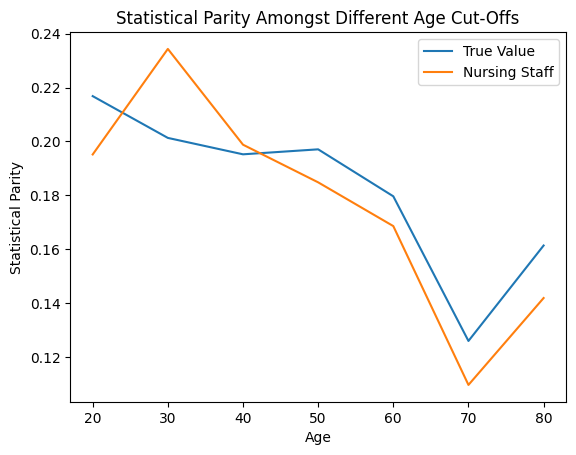

In [50]:
plt.plot([20, 30, 40, 50, 60, 70, 80], age_bias_stats[0:7], label = 'True Value')
plt.plot([20, 30, 40, 50, 60, 70, 80], nurse_age_bias_stats, label = 'Nursing Staff')
plt.title('Statistical Parity Amongst Different Age Cut-Offs')
plt.xlabel('Age')
plt.ylabel('Statistical Parity')
plt.legend()
plt.clf

# Preprocessing For Modelling Continued.

In [51]:
train_df = train_df.drop(labels = ["KTAS_expert"], axis=1)

In [52]:
scaler = StandardScaler()

for item in train_df.columns:
        try:
            scaler = StandardScaler()
            new_list = list(train_df[item])
            new_list = np.array(new_list)
            new_list = new_list.reshape(-1, 1)
            scaler.fit(new_list)
            train_df[item] = scaler.transform(new_list)
        except:
            print(str(item) + " is not a num type")


Chief_complain is not a num type
Diagnosis in ED is not a num type


In [53]:
train_df.dtypes

Gender             float64
Age                float64
Arrival mode       float64
NRS_pain           float64
Injury             float64
Chief_complain      object
Mental             float64
Pain               float64
SBP                float64
DBP                float64
HR                 float64
RR                 float64
BT                 float64
Saturation         float64
Diagnosis in ED     object
Emergency          float64
Age_Bin            float64
dtype: object

In [54]:
vector = TfidfVectorizer()
vectorlist = vector.fit_transform(train_df['Chief_complain'])
vector2 = TfidfVectorizer()
vectorlist2 = vector2.fit_transform(train_df['Diagnosis in ED'])

In [55]:
vectorlist

<1267x305 sparse matrix of type '<class 'numpy.float64'>'
	with 2431 stored elements in Compressed Sparse Row format>

In [56]:
testdf = train_df.drop(labels= ["Chief_complain", "Diagnosis in ED"], axis = 1)
training_data = sparse.hstack((vectorlist, testdf))
training_data = sparse.hstack((vectorlist2, training_data))

In [57]:
# Learning Curve
testdf.shape
resampling = [10, 50, 100, 250, 500, 750, 1000]

Train/Test Split

In [58]:
from sklearn.metrics import balanced_accuracy_score
f_training_acc = []
f_training_bin_acc = []
SVM_train = []
SVM_train_bin_acc = []
for i in resampling:
    i /= 1267
    X_train, X_test, y_train, y_test = train_test_split(training_data, target, train_size =i, test_size = 0.2, random_state=3)
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(training_data, target_c, train_size=i, test_size = 0.2, random_state=3)
    forest = RandomForestClassifier(random_state=3)
    forest2 = RandomForestClassifier(random_state=3)
    print(f'sample size {i:.3f}')
    forest = RandomForestClassifier()
    forest.fit(X_train, y_train)
    forest_prediction = forest.predict(X_test)
    forest_c = RandomForestClassifier()
    forest_c.fit(X_train_c, y_train_c)
    forest_prediction_c = forest_c.predict(X_test_c)
    forest_score = balanced_accuracy_score(y_test, forest_prediction)
    forest_score_c = balanced_accuracy_score(y_test_c, forest_prediction_c)
    f_training_acc.append(forest_score)
    f_training_bin_acc.append(forest_score_c)
    vector = SVC()
    vector.fit(X_train, y_train)
    SVMprediction = vector.predict(X_test)
    vector_c = SVC()
    vector_c.fit(X_train_c, y_train_c)
    SVMprediction_c = vector_c.predict(X_test_c)
    SVMscore = balanced_accuracy_score(y_test, SVMprediction)
    SVMscore_c = balanced_accuracy_score(y_test_c, SVMprediction_c)
    SVM_train.append(SVMscore)
    SVM_train_bin_acc.append(SVMscore_c)


print(f_training_acc)
print(f_training_bin_acc)
print(SVM_train)
print(SVM_train_bin_acc)

sample size 0.008


sample size 0.039
sample size 0.079
sample size 0.197
sample size 0.395
sample size 0.592
sample size 0.789
[0.3327743910087554, 0.3294192318306114, 0.38865106244198594, 0.43957050751360977, 0.442309525601465, 0.5370898156809197, 0.5413867475190572]
[0.746692733789508, 0.8023460410557185, 0.8877810361681329, 0.9093841642228739, 0.9309872922776149, 0.9130335614206582, 0.9245356793743891]
[0.2088888888888889, 0.33754797922781665, 0.3549785504628584, 0.3727563282406362, 0.4017485763026517, 0.4840001863618933, 0.5087251054557445]
[0.7292929292929293, 0.8740306288693385, 0.9047572499185403, 0.9130335614206582, 0.9180840664711633, 0.9231345715216683, 0.9249592701205605]


Text(0.5, 0, 'Sample Size')

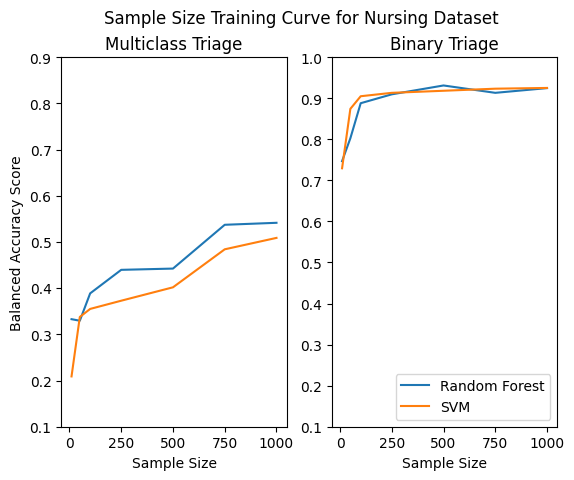

In [59]:
# make training plot
"""ax = plt.subplot(2, 1, 2)
ax1 = plt.subplot(1, 1, 1)
plt.subplot()
plt.plot(resampling, f_training_acc)
plt.plot(resampling, SVM_train)
ax2 = plt.subplot(2, 1, 2)
plt.plot(resampling, f_training_bin_acc)
plt.plot(resampling, SVM_train_bin_acc)
plt.show()
plt.clf()
"""

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sample Size Training Curve for Nursing Dataset')
ax1.plot(resampling, f_training_acc)
ax1.plot(resampling, SVM_train)
ax1.set_ylim(0.1, 0.9)
ax1.set_title('Multiclass Triage')
ax1.set_ylabel('Balanced Accuracy Score')
ax1.set_xlabel('Sample Size')
ax2.plot(resampling, f_training_bin_acc, label = 'Random Forest')
ax2.plot(resampling, SVM_train_bin_acc, label = 'SVM')
ax2.set_ylim(0.1, 1.0)
ax2.set_title('Binary Triage')
ax2.legend(loc = 4)
ax2.set_xlabel('Sample Size')

Model Testing Number

Logistic Regression

Random Forest Hyper Parameter Tuning

In [60]:
paramgrid = {'n_estimators': [2, 5, 10, 20, 50, 100, 500], 'min_samples_split':[2, 3, 4, 5], 'min_samples_leaf':[1, 2, 3, 4, 5, 6]}
forest = RandomForestClassifier(random_state=3)
forest_grid = GridSearchCV(estimator=forest, param_grid=paramgrid, refit = True)
forest_grid.fit(X_train, y_train)
forest2 = RandomForestClassifier(random_state=3)
forest_grid2 = GridSearchCV(estimator=forest2, param_grid=paramgrid, refit=True, scoring = 'roc_auc')
forest_grid2.fit(X_train_c, y_train_c)

GridSearchCV(estimator=RandomForestClassifier(random_state=3),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [2, 5, 10, 20, 50, 100, 500]},
             scoring='roc_auc')

In [61]:
print(forest_grid.best_params_)
print(forest_grid2.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
{'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}


In [62]:
forest = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 3, n_estimators = 500, random_state=3)
forest.fit(X_train, y_train)
forest_prediction = forest.predict(X_test)

forest_c = RandomForestClassifier(min_samples_leaf= 1, min_samples_split=5, n_estimators=500, random_state=3)
forest_c.fit(X_train_c, y_train_c)
forest_prediction_c = forest_c.predict(X_test_c)

from sklearn.metrics import balanced_accuracy_score
forest_score = balanced_accuracy_score(y_test, forest_prediction)
forest_score_c = balanced_accuracy_score(y_test_c, forest_prediction_c)


print(forest_score)
print(forest_score_c)

0.5460083074397818
0.9281850765721733


In [63]:
SVMparam = {'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf', 'linear', 'poly']}
SVC_ = SVC(random_state=3)
grid = GridSearchCV(SVC_, SVMparam, refit=True, verbose=3)
grid2 = GridSearchCV(SVC_, SVMparam, refit=True, verbose=3, scoring = 'roc_auc')

In [64]:
grid.fit(X_train, y_train)
grid2.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.385 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.385 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.380 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.380 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.382 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.745 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.695 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.765 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.740 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.734 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.730 total time=   0.1s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

GridSearchCV(estimator=SVC(random_state=3),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='roc_auc', verbose=3)

In [65]:
print(grid.best_params_)
print(grid2.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [66]:
vector = SVC(C = 100, gamma= 0.001, kernel='rbf', probability=True, random_state=3)
vector.fit(X_train, y_train)
SVMprediction = vector.predict(X_test)

vector_c = SVC(C = 100, gamma = 0.001, kernel='rbf', probability=True, random_state=3)
vector_c.fit(X_train_c, y_train_c)
SVMprediction_c = vector_c.predict(X_test_c)

SVMscore = accuracy_score(y_test, SVMprediction)
SVMscore_c = accuracy_score(y_test_c, SVMprediction_c)

print(SVMscore)
print(SVMscore_c)

0.7559055118110236
0.9251968503937008


Text(0.5, 1.0, 'SVM Emergency Performance')

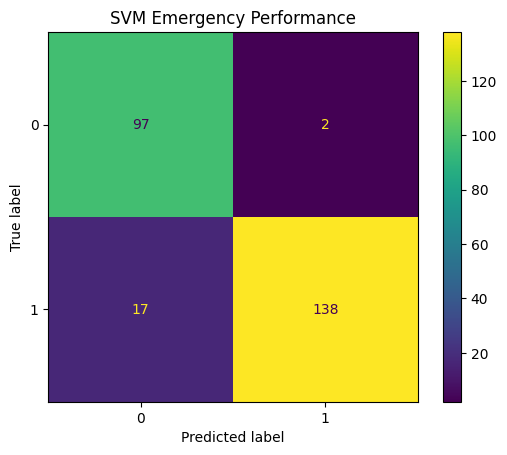

In [67]:
cm1 = confusion_matrix(y_test_c, SVMprediction_c, labels = vector_c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.title("SVM Emergency Performance")

Text(0.5, 1.0, 'Forest Emergency Performance')

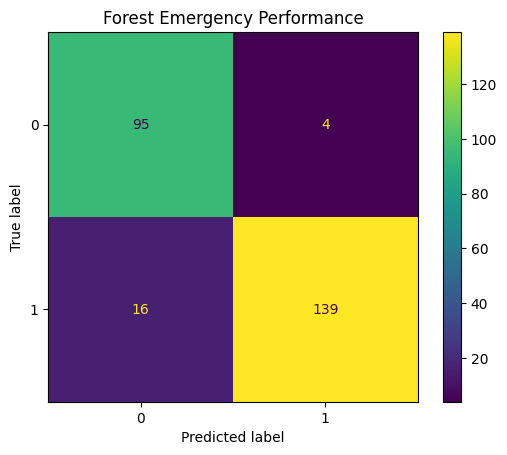

In [68]:
cm2 = confusion_matrix(y_test_c, forest_prediction_c, labels = forest_c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.title("Forest Emergency Performance")


Text(0.5, 1.0, 'Nurse Emergency Performance')

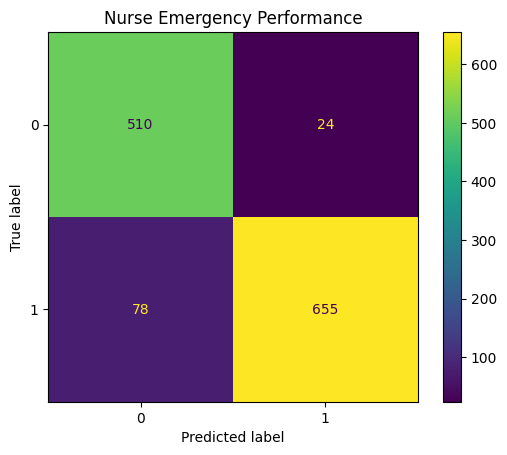

In [69]:
cm3 = confusion_matrix(human_compare['CAT_EXPERT'], human_compare['CAT_RN'], labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=[0, 1])
disp.plot()
plt.title("Nurse Emergency Performance")

In [70]:
human_compare.columns

Index(['KTAS_RN', 'KTAS_expert', 'CAT_RN', 'CAT_EXPERT'], dtype='object')

In [71]:
len(human_compare[human_compare['KTAS_expert'] == 1])

26

Text(0.5, 1.0, 'Nurse Emergency Performance')

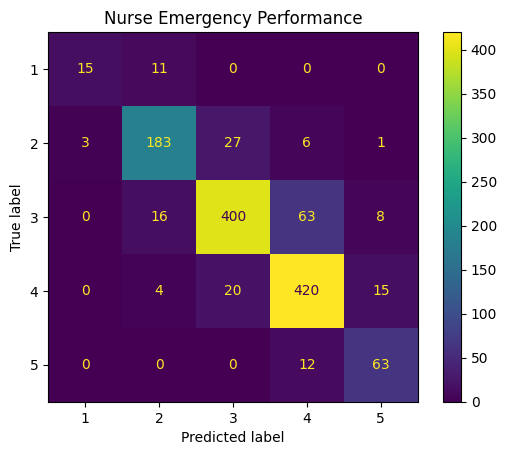

In [72]:
cm4 = confusion_matrix(human_compare['KTAS_expert'], human_compare['KTAS_RN'], labels = [1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.title("Nurse Emergency Performance")

Text(0.5, 1.0, 'Forest Emergency Performance')

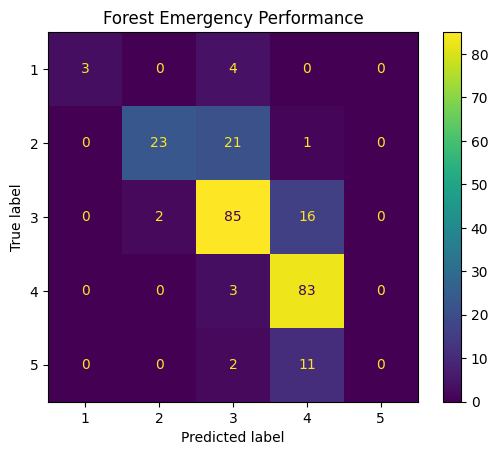

In [73]:
cm5 = confusion_matrix(y_test, forest_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.title("Forest Emergency Performance")

In [74]:
rf_roc = forest_c.predict_proba(X_test_c)
rf_roc = rf_roc[:,1]
rf_auc_score = roc_auc_score(y_test_c, rf_roc)
rf_fpr, rf_tpr, _ = roc_curve(y_test_c, rf_roc)

In [75]:
r_line = [0 for _ in range (len(y_test_c))]
r_auc_score = roc_auc_score(y_test_c, r_line)
r_fpr, r_tpr, _ = roc_curve(y_test_c, r_line)

In [76]:
SM_roc_c = vector_c.predict_proba(X_test_c.toarray())[:, 1]
SM_auc_score = roc_auc_score(y_test_c, SM_roc_c)
SM_fpr, SM_tpr, _ = roc_curve(y_test_c, SM_roc_c)

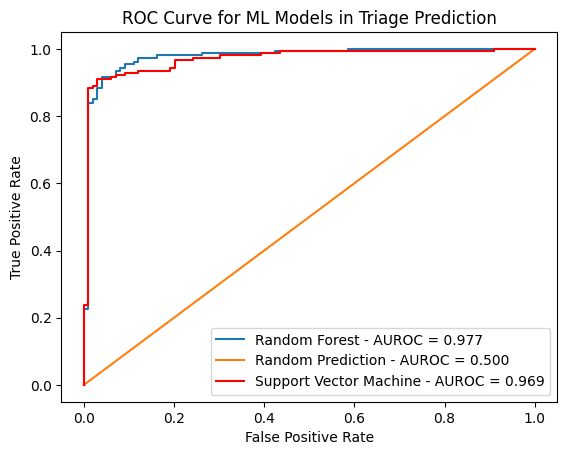

In [77]:
plt.plot(rf_fpr, rf_tpr, label = "Random Forest - AUROC = %0.3f" % rf_auc_score)
plt.plot(r_fpr, r_tpr, label = "Random Prediction - AUROC = %0.3f" % r_auc_score)
plt.plot(SM_fpr, SM_tpr, label = "Support Vector Machine - AUROC = %0.3f" % SM_auc_score, color= 'red')
plt.legend()
plt.title('ROC Curve for ML Models in Triage Prediction')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [78]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score

In [79]:
nurse_metrics = precision_recall_fscore_support(human_compare['CAT_EXPERT'], human_compare['CAT_RN'])
nurse_ba = balanced_accuracy_score(human_compare['CAT_EXPERT'], human_compare['CAT_RN'])

In [80]:
forest_metrics = precision_recall_fscore_support(y_test_c, forest_prediction_c)
forest_ba = balanced_accuracy_score(y_test_c, forest_prediction_c)
svm_metrics = precision_recall_fscore_support(y_test_c, SVMprediction_c)
svm_ba = balanced_accuracy_score(y_test_c, SVMprediction_c)

In [81]:
print(nurse_metrics)

(array([0.86734694, 0.9646539 ]), array([0.95505618, 0.89358799]), array([0.90909091, 0.92776204]), array([534, 733]))


In [82]:
print(forest_metrics)

(array([0.85585586, 0.97202797]), array([0.95959596, 0.89677419]), array([0.9047619 , 0.93288591]), array([ 99, 155]))


Text(0.5, 1.0, 'Nurse Emergency Performance')

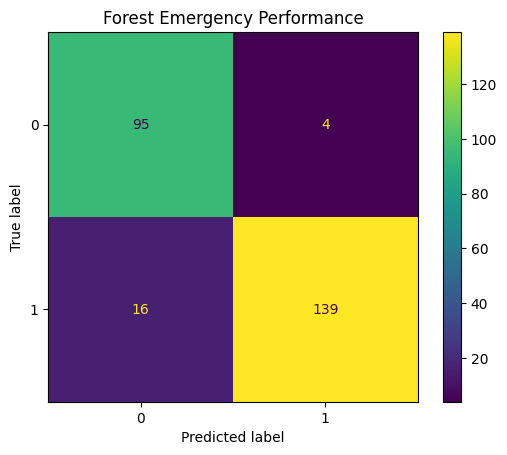

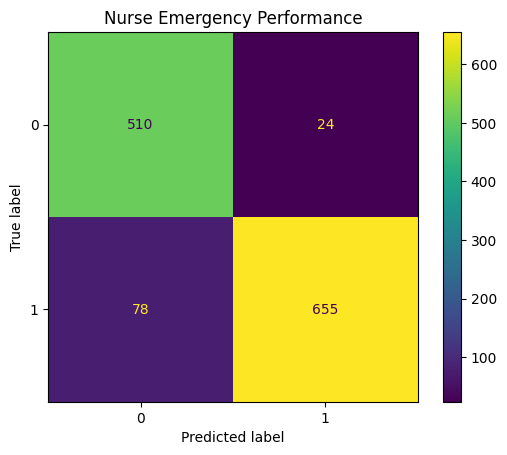

In [83]:
cm2 = confusion_matrix(y_test_c, forest_prediction_c, labels = forest_c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.title("Forest Emergency Performance")

cm3 = confusion_matrix(human_compare['CAT_EXPERT'], human_compare['CAT_RN'], labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=[0, 1])
disp.plot()
plt.title("Nurse Emergency Performance")

In [84]:
prec = [round(nurse_metrics[0][1], 3),round(forest_metrics[0][1], 3), round(svm_metrics[0][1], 3)]
rec = [round(nurse_metrics[1][1],3),round(forest_metrics[1][1],3), round(svm_metrics[1][1], 3)]
f1 = [round(nurse_ba,3),round(forest_ba,3), round(svm_ba, 3)]

In [85]:
index = ['nurse', 'forest', 'SVM']
data = {'index': index,
        'precision': prec,
        'recall': rec,
        'balanced accuracy': f1}

In [86]:
metrics_df = pd.DataFrame(data)

In [87]:
metrics_df

,index,precision,recall,balanced accuracy
0,nurse,0.965,0.894,0.924
1,forest,0.972,0.897,0.928
2,SVM,0.986,0.890,0.935


In [88]:


nurse_multi = balanced_accuracy_score(human_compare['KTAS_expert'], human_compare['KTAS_RN'])

forest_multi = balanced_accuracy_score(y_test, forest_prediction)

SVM_multi = balanced_accuracy_score(y_test, SVMprediction)

In [89]:
print("Nurse Multinomial Classification Balanced Accuracy Score: " + str(round(nurse_multi, 3)))

Nurse Multinomial Classification Balanced Accuracy Score: 0.797


In [90]:
print("Forest Multinomial Classification Balanced Accuracy Score: " + str(round(forest_multi, 3)))

Forest Multinomial Classification Balanced Accuracy Score: 0.546


In [91]:
print("SVM Multinomial Classification Balanced Accuracy Score: " + str(round(SVM_multi, 3)))

SVM Multinomial Classification Balanced Accuracy Score: 0.524
